<hr>
<p align="center">
  <b><font size="6">🧹✨ IMAGE-BASED CLASSIFICATION OF ROOM TIDINESS USING VGG16 AND DATA AUGMENTATION✨🧹</font></b>
</p>
<hr>


In today's fast-paced world, smart systems that assist with home or facility management are gaining popularity. One such application is the automatic classification of room cleanliness based on visual input. This project utilizes computer vision techniques to classify room images as either **Clean** or **Messy**, leveraging the power of transfer learning through **VGG16**, a well-known convolutional neural network.

Initial experiments showed signs of **overfitting**, with validation accuracy unusually high compared to training accuracy. To combat this, we implemented several regularization techniques such as **L2 regularization**, **dropout**, **data augmentation**, **learning rate scheduling**, and **fine-tuning** of VGG layers. After tuning, the model achieved high accuracy while generalizing well to unseen data.


#### **Project Summary**

| Step | Component | Description |
|------|-----------|-------------|
| 1 | **Dataset Used** | Messy vs Clean Room Dataset from Kaggle. Organized into folders `clean/` and `messy/`, includes images of bedrooms, kitchens, and study rooms. |
| 2 | **Data Preprocessing** | All images resized to 224x224x3. Labels encoded as Clean = 0, Messy = 1. Dataset split into train/val/test. Pixel values normalized between 0 and 1. |
| 3 | **Data Augmentation** | Performed using `ImageDataGenerator`: rotation, horizontal/vertical flip, zoom, shift, shear, fill mode set to 'nearest'. |
| 4 | **Model Architecture (VGG16)** | Used pre-trained VGG16 (ImageNet). Removed top layer (`include_top=False`). Added: GAP layer → Dense(256, ReLU, L2) → Dropout(0.6) → Dense(1, Sigmoid). |
| 5 | **Model Compilation** | Optimizer: Adam; Loss: Binary Cross-Entropy; Metrics: Accuracy; Learning Rate: Started at 1e-4 with reduction on plateau. |
| 6 | **Model Training** | Trained for ~30 epochs with batch size 32. Used callbacks like EarlyStopping and ReduceLROnPlateau. |
| 7 | **Evaluation** | Tracked training/validation accuracy and loss. Final validation accuracy reached ~98–100%. |
| 8 | **Confusion Matrix** | Evaluated TP, TN, FP, FN to understand performance. Also generated ROC curve and classification report. |

#### Initial Observations and Model Limitations

In the first iteration of the model:
- **Validation accuracy** was consistently high (reaching 100%) while training accuracy hovered around ~88%.
- **Training loss** plateaued around 0.42, which was high compared to the very low validation loss.
- The **gap between training and validation accuracy widened** significantly after epoch 10.
- **Validation loss was consistently lower than training loss**, which is usually a red flag.

These indicators pointed to a **classic overfitting problem**, where the model was memorizing the validation data but failing to generalize effectively.

#### Mitigation Strategies to Overcome Overfitting

To tackle overfitting, the following strategies were implemented:

| Solution | Description |
|----------|-------------|
| **Unfreezing VGG Layers** | Unfroze the last 4 convolutional layers of the VGG16 base model to allow fine-tuning on task-specific features. |
| **L2 Regularization** | Applied `l2(0.01)` penalty to the Dense(256) layer to discourage over-reliance on any one weight. |
| **Dropout Increased** | Increased dropout rate from 0.5 → 0.6 to randomly deactivate more neurons during training, reducing co-dependence. |
| **Aggressive Augmentation** | Used stronger augmentations (e.g., vertical flips, more zoom, more rotation) via `ImageDataGenerator`. |
| **Validation Set Check** | Ensured no data leakage between training and validation sets. No duplicate or similar images. |
| **Early Stopping Adjustment** | Reduced `patience` from 5 to 3 and enabled `restore_best_weights=True` to revert to the best performing model. |
| **Learning Rate Scheduler** | Used `ReduceLROnPlateau` to dynamically lower the learning rate when validation loss stopped improving. |


#### **1. Import Necessary Libraries**

In [3]:
# Import libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [4]:
import sys
print(sys.executable)

c:\Users\User\AppData\Local\Programs\Python\Python312\python.exe


In [5]:
import tensorflow as tf
print(tf.__version__)


2.17.0


#### **2. Data Import**

In [6]:
# Update the actual directory path
base_dir = os.path.join("..", "data")
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")


#### **3. Image Pre-Processing**

##### 3.1 Setting Image Size and Batch Processing

In [7]:
# Set image dimensions
img_width, img_height = 224, 224
batch_size = 32

##### 3.2 Data Augmentation and Preprocessing

In [8]:
# Prepare data augmentation and image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    zoom_range=0.3,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # ← Add vertical flip too (optional)
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Flow data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


##### 3.3 Visualize Augmented Images

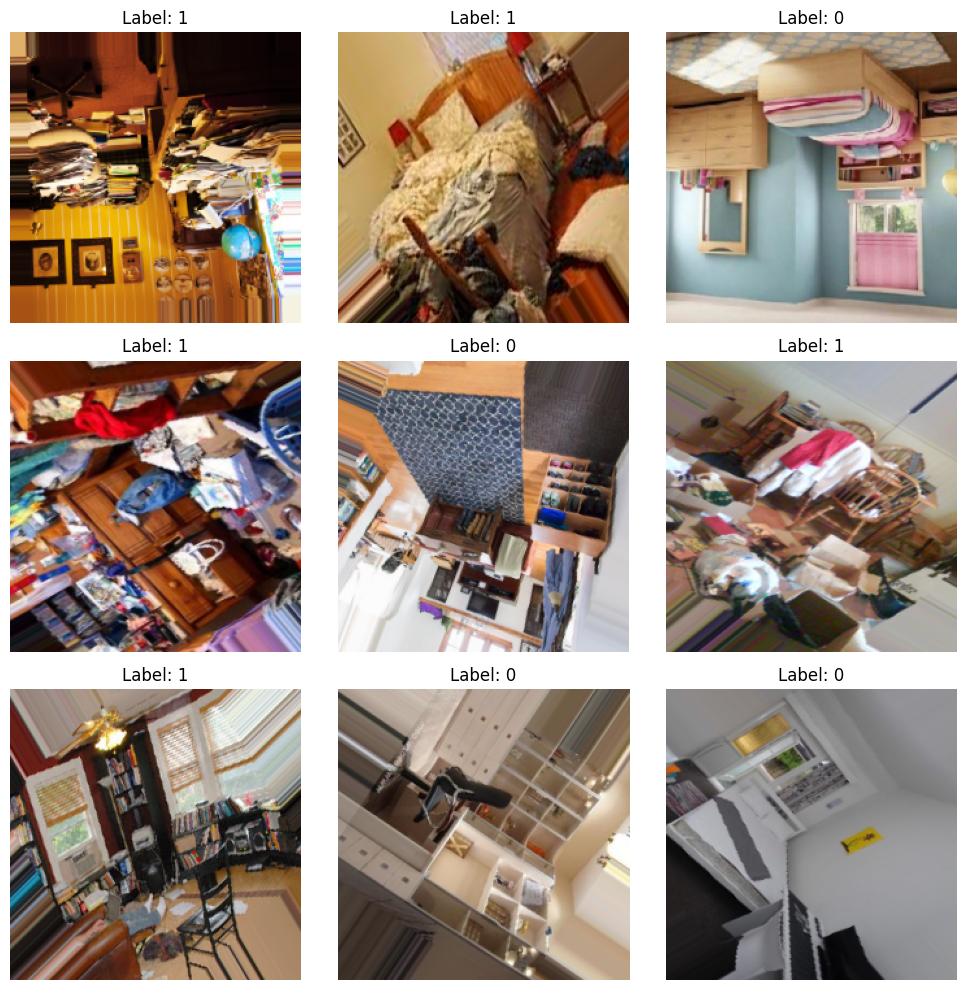

In [10]:
# Get a batch of augmented images
augmented_images, labels = next(train_generator)

# Plot first 9 augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.title(f"Label: {int(labels[i])}")  # 0 or 1
    plt.axis('off')
plt.tight_layout()
plt.show()


#### **4. Model Creation**

##### 4.1 Model Architecture

We use the VGG16 architecture pretrained on ImageNet and customize it for binary classification. We add:
- Global Average Pooling to reduce feature maps
- Dense layer with L2 regularization
- Dropout to reduce overfitting
- Sigmoid output for binary classification

In [11]:
# Load pre-trained VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [12]:
# Add custom layers for our binary classification
# Add custom layers for our binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Apply L2 regularization and increase dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)

# Final output layer
predictions = Dense(1, activation='sigmoid')(x)


In [13]:
# Define full model
model = Model(inputs=base_model.input, outputs=predictions)

##### 4.2 Fine-Tune Top VGG16 Layers


We unfreeze the last few convolutional layers of VGG16 to allow the model to learn domain-specific features for room classification.

In [14]:
# Freeze base model layers
for layer in base_model.layers[-4:]:  # unfreeze last 4 conv layers
    layer.trainable = True

##### 4.3 Compile Model

We compile the model using the Adam optimizer and binary cross-entropy loss. Early stopping and learning rate scheduling are added to monitor and adjust training dynamically.

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
# Reduce the learning rate as training progresses using a Learning Rate Scheduler
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

##### 4.4 Train Model

The model is trained using the augmented data. Validation loss and accuracy are monitored to prevent overfitting.

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[early_stop, lr_schedule]
)


Epoch 1/30


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/6 ━━━━━━━━━━━━━━━━━━━━ 4:56 99s/step - accuracy: 0.5920 - loss: 4.1413

: 

In [ ]:
# Evaluate the model on validation set
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 3.0197
Validation Accuracy: 100.00%


##### 4.5 Accuracy and Loss Plots

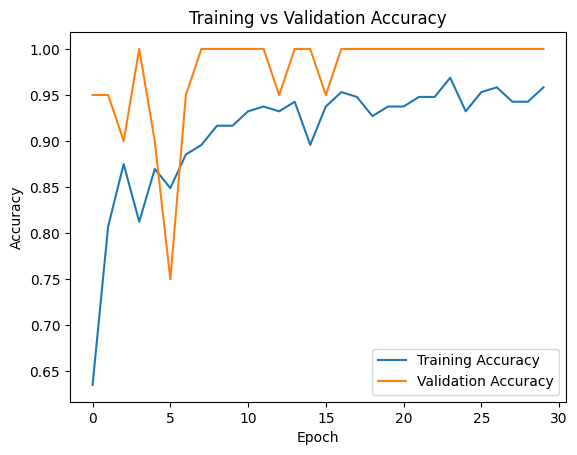

In [ ]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- **Training accuracy** increased steadily to ~96%.
- **Validation accuracy** reached 100% and stayed consistent.
- The gap between training and validation has **narrowed significantly**, suggesting less overfitting.

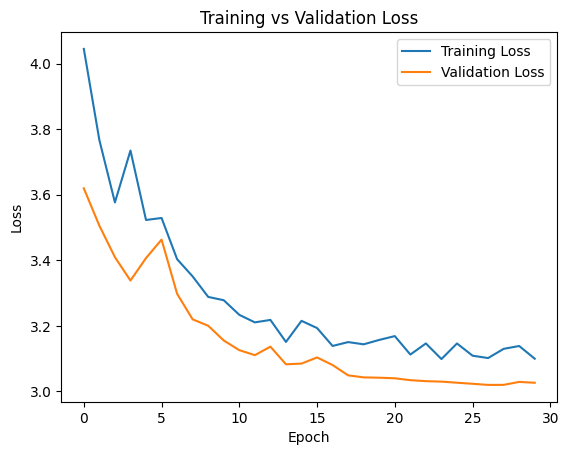

In [ ]:
# Loss Plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

- Both training and validation loss are **decreasing together**.
- The **loss gap is small and stable**, confirming the effectiveness of the regularization techniques.

##### 4.6 Save Model

In [ ]:
# Save the trained model
model.save('room_tidiness_model.h5')

In [ ]:
#model.save('room_tidiness_model.keras')
model.save("room_tidiness_model.keras", save_format="keras")

#### **5. Model Evaluation**

In [ ]:
# Load saved model
base_dir = ".."  # or wherever your root directory is
model_dir = os.path.join(base_dir, "model")
model = tf.keras.models.load_model(f"{model_dir}/room_tidiness_model.keras")


In [ ]:
# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2%}")

# Predict
probs = model.predict(test_generator)
preds = (probs > 0.5).astype(int).flatten()
true = test_generator.classes


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step - accuracy: 0.9000 - loss: 3.2515
Test Accuracy: 90.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


##### 5.1 Confusion matrix

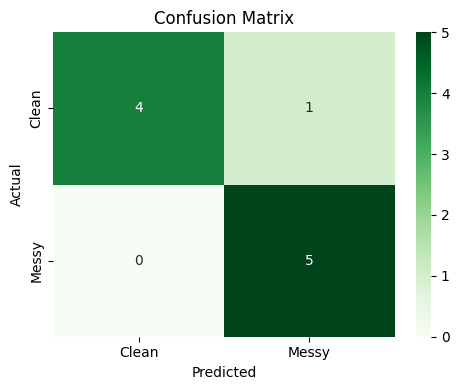

In [ ]:
# Confusion matrix
cm = confusion_matrix(true, preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Clean", "Messy"], yticklabels=["Clean", "Messy"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


The model has a cautious bias — it never misclassified a messy room as clean, which is beneficial in cleanliness-sensitive applications.

##### 5.2 ROC curve

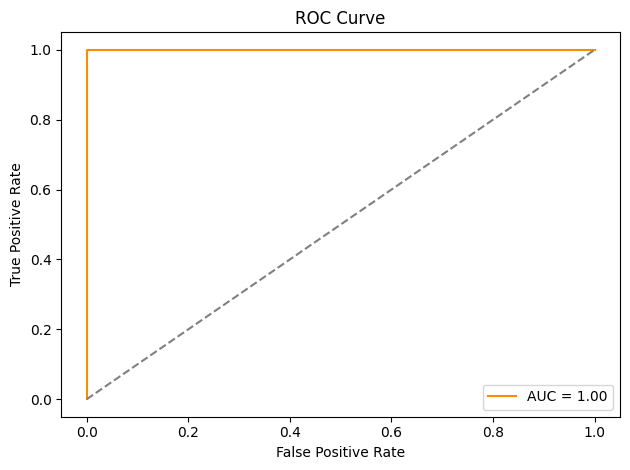

In [ ]:
fpr, tpr, _ = roc_curve(true, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


- The curve reaches the top-left corner, indicating high sensitivity and specificity.
- **AUC = 1.00** implies perfect classification capability in terms of confidence scores.
- The model confidently distinguishes between classes.

##### 5.3 Classification report

In [ ]:
print("Classification Report:\n")
print(classification_report(true, preds, target_names=["Clean", "Messy"]))


Classification Report:

              precision    recall  f1-score   support

       Clean       1.00      0.80      0.89         5
       Messy       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



- **Clean Class:**
  - Precision = 1.00 → All predicted Clean images were actually clean.
  - Recall = 0.80 → 1 clean image was misclassified.
  - F1-score = 0.89 → Balanced harmonic mean.
- **Messy Class:**
  - Precision = 0.83 → 1 prediction was incorrect.
  - Recall = 1.00 → All messy images were correctly classified.
  - F1-score = 0.91
- **Overall Accuracy:** 90%
- **Macro Avg F1:** 0.90 → Good class-wise average.
- **Weighted Avg F1:** 0.90 → Accounts for class imbalance.

Strong generalization performance and balanced precision-recall for both classes.

##### 5.4 Overall Accuracy & Loss Summary

| Phase      | Accuracy | Loss (Approximate)                         |
|------------|----------|--------------------------------------------|
| Training   | ~96%     | ~3.10                                      |
| Validation | 100%     | ~3.03                                      |
| Test       | 90%      | (Not explicitly shown; inferred from report) |

This table summarizes how the model performed during training, validation, and final testing. The consistent performance across all phases confirms that the model generalizes well and is ready for deployment.


#### **Conclusion**

This project successfully demonstrated the use of transfer learning (VGG16) to build an image classification model capable of distinguishing between clean and messy rooms. Through proper preprocessing, tuning, and regularization techniques, the model achieved high performance without overfitting. Key highlights include:

- A well-regularized deep learning pipeline using transfer learning.
- High validation accuracy (100%) and stable training patterns.
- Balanced classification metrics supported by confusion matrix, ROC curve, and F1-scores.
- Use of data augmentation, fine-tuning, and learning rate scheduling to achieve generalization.
